In [5]:
%load_ext autoreload
%autoreload 2
from targets.conditional_density_estimation_target import *
torch.manual_seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


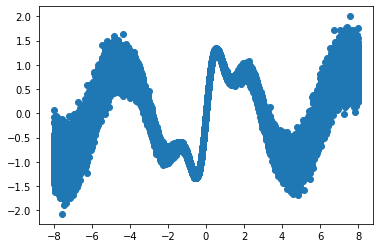

In [6]:
target = Wave()
theta = target.sample_prior(50000)
x = target.simulate(theta)
fig = plt.scatter(theta.squeeze(-1).numpy(), x.squeeze(-1).numpy())
plt.show()

torch.Size([1])


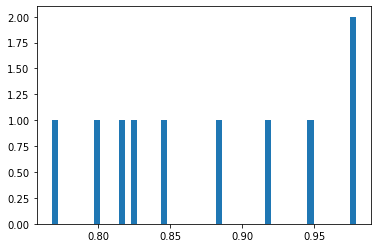

In [7]:
theta_0 = torch.tensor([2])
print(theta_0.shape)
num_observations = 10
x_0 = target.simulate(theta_0.unsqueeze(0).repeat(num_observations,1))
plt.figure()
hist = plt.hist(x_0.detach().numpy(), bins =50)

In [8]:
from models_dif import ConditionalDIFDensityEstimator
architecture = ConditionalDIFDensityEstimator
K = 2
hidden_dimensions = [5,5]
from prettytable import PrettyTable

def count_parameters():
    model = architecture(x, theta,K,hidden_dimensions)
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
number_param = count_parameters()
print(number_param)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| w.f.0.weight |     10     |
|  w.f.0.bias  |     5      |
| w.f.2.weight |     25     |
|  w.f.2.bias  |     5      |
| w.f.4.weight |     10     |
|  w.f.4.bias  |     2      |
| T.f.0.weight |     5      |
|  T.f.0.bias  |     5      |
| T.f.2.weight |     25     |
|  T.f.2.bias  |     5      |
| T.f.4.weight |     20     |
|  T.f.4.bias  |     4      |
+--------------+------------+
Total Trainable Params: 121
121


In [9]:
import copy 
def metropolis_adjusted_langevin_step(current_model,data,tau):
    
    #evaluate current model
    current_model.zero_grad()
    log_prob = -current_model.loss(data)*data.shape[0]
    log_prob.backward()
    print(log_prob)
    
    #copy model
    copy_model = copy.deepcopy(current_model)
    for param, copy_param in zip(current_model.parameters(), copy_model.parameters()):
        with torch.no_grad():
            copy_param.data= param.data+tau*param.grad + torch.randn_like(param.data)*((2*tau)**(1/2))
            print(torch.nn.utils.parameters_to_vector())
            
    #compute copy_loss
    copy_model.zero_grad()
    copy_log_prob = -copy_model.loss(data)*data.shape[0]
    copy_log_prob.backward()
    print(copy_log_prob) 
    
    #compute proposal densities
    with torch.no_grad():
        log_ratio = 0
        for param, new_param in zip(current_model.parameters(),copy_model.parameters()):
            log_ratio -= torch.sum(torch.square(param - new_param - tau*new_param.grad))/(4*tau)
            log_ratio += torch.sum(torch.square(new_param - param - tau*param.grad))/(4*tau)
        #acceptation probability
        acceptance_log_prob = copy_log_prob - log_prob + log_ratio
        print(torch.exp(acceptance_log_prob))
        if torch.rand(1)<torch.exp(acceptance_log_prob):
            print('accepted')
            return copy_model
        else:
            print('denied')
            return current_model
    return copy_model


In [11]:
from IPython.display import clear_output
theta_linspace = torch.linspace(-8.,8.,100)
x_linspace = torch.linspace(-2.,2.,100)
grid_theta,grid_x = torch.meshgrid(theta_linspace, x_linspace, indexing = 'ij')

trained_model = ConditionalDIFDensityEstimator(x, theta, K, hidden_dimensions)
#trained_model.train(100,5000)
metropolis_adjusted_langevin_step()

  2%|██▎                                                                                                                   | 2/100 [00:03<02:40,  1.64s/it, loss = 1.200821 ; device: cpu]


KeyboardInterrupt: 

In [19]:
current_model = trained_model
current_theta = torch.randn(1)
current_theta.requires_grad = True
log_prob = -current_model.loss(x, theta)*x.shape[0] + torch.sum(current_model.log_density(x_0, current_theta.unsqueeze(0).repeat(x_0.shape[0],1)))
log_prob.backward()
vector_of_params = torch.nn.utils.parameters_to_vector(current_model.parameters())
print(torch.nn.utils.parameters_to_vector(current_model.parameters()))
'''
for i in range(20000):
    #copy model
    copy_theta = copy.deepcopy(current_theta)
    with torch.no_grad():
        copy_theta.data = current_theta.data + tau*current_theta.grad + torch.randn_like(current_theta.data)*((2*tau)**(1/2))
    copy_model = copy.deepcopy(current_model)
    for param, copy_param in zip(current_model.parameters(), copy_model.parameters()):
        with torch.no_grad():
            copy_param.data= param.data+tau*param.grad + torch.randn_like(param.data)*((2*tau)**(1/2))
            
    #compute copy_loss
    copy_model.zero_grad()
    copy_log_prob = -copy_model.loss(x, theta)*x.shape[0] + torch.sum(copy_model.log_density(x_0, copy_theta.unsqueeze(0).repeat(x_0.shape[0],1)))
    copy_log_prob.backward()
    clear_output(wait = True)
    plt.figure()
    with torch.no_grad():
        density = current_model.log_density(grid_x.unsqueeze(-1), grid_theta.unsqueeze(-1))
        plt.pcolormesh(grid_theta, grid_x,torch.exp(density).detach().numpy())
        plt.show()
    print(log_prob)
    print(copy_log_prob) 
    
    #compute proposal densities
    with torch.no_grad():
        log_ratio = torch.sum(torch.square(copy_theta - current_theta - tau*current_theta.grad))/(4*tau)-torch.sum(torch.square(current_theta - copy_theta - tau*copy_theta.grad))/(4*tau)
        for param, new_param in zip(current_model.parameters(),copy_model.parameters()):
            log_ratio -= torch.sum(torch.square(param - new_param - tau*new_param.grad))/(4*tau)
            log_ratio += torch.sum(torch.square(new_param - param - tau*param.grad))/(4*tau)
        #acceptation probability
        acceptance_log_prob = copy_log_prob - log_prob + log_ratio
        if torch.rand(1)<torch.exp(acceptance_log_prob):
            print('accepted')
            current_model = copy_model
            log_prob = copy_log_prob
            current_theta = copy_theta
        samples.append(current_theta)
    
    all_samples = torch.cat(samples, dim =0)
    plt.figure()
    hist = plt.hist(all_samples.detach().numpy())
    plt.show()
'''

tensor([ 7.0341e-01, -2.0039e-02,  3.2170e-01, -9.5995e-03,  2.5619e-02,
         4.6398e-01,  5.0563e-02, -1.8774e-01,  1.3051e-01, -2.8921e-01,
         3.4830e-01, -5.3637e-01, -3.0655e-01,  6.8290e-02, -4.7395e-01,
        -1.8752e-01,  2.8750e-01,  2.1097e-01,  4.0853e-01,  4.5567e-01,
        -2.9400e-01,  3.1306e-01,  1.4136e-01, -2.8493e-01,  3.4480e-02,
        -3.1202e-01,  1.7379e-01, -1.4647e-02, -9.7923e-02, -3.2480e-01,
        -2.8382e-01, -3.2811e-01,  2.6148e-02,  2.4343e-01,  2.4684e-01,
        -7.8789e-02, -4.5943e-01, -1.8847e-01, -7.4056e-03,  1.8167e-01,
         4.1986e-03,  2.1288e-01, -2.3171e-01,  3.5087e-01,  4.2087e-01,
         8.5097e-02, -3.2848e-01, -2.1897e-01,  3.5485e-01,  5.4850e-01,
         2.9780e-01,  6.0953e-02, -1.7167e-01, -5.3609e-01, -5.5009e-01,
        -1.2695e-01, -3.2559e-02, -7.4864e-01,  1.5028e-01, -3.7085e-01,
        -1.0120e+00,  1.3730e-01, -6.6983e-01,  1.0100e+00,  7.2199e-01,
        -2.4329e-01,  1.0539e+00,  3.8684e-01, -2.8

"\nfor i in range(20000):\n    #copy model\n    copy_theta = copy.deepcopy(current_theta)\n    with torch.no_grad():\n        copy_theta.data = current_theta.data + tau*current_theta.grad + torch.randn_like(current_theta.data)*((2*tau)**(1/2))\n    copy_model = copy.deepcopy(current_model)\n    for param, copy_param in zip(current_model.parameters(), copy_model.parameters()):\n        with torch.no_grad():\n            copy_param.data= param.data+tau*param.grad + torch.randn_like(param.data)*((2*tau)**(1/2))\n            \n    #compute copy_loss\n    copy_model.zero_grad()\n    copy_log_prob = -copy_model.loss(x, theta)*x.shape[0] + torch.sum(copy_model.log_density(x_0, copy_theta.unsqueeze(0).repeat(x_0.shape[0],1)))\n    copy_log_prob.backward()\n    clear_output(wait = True)\n    plt.figure()\n    with torch.no_grad():\n        density = current_model.log_density(grid_x.unsqueeze(-1), grid_theta.unsqueeze(-1))\n        plt.pcolormesh(grid_theta, grid_x,torch.exp(density).detach().nu